# FSC

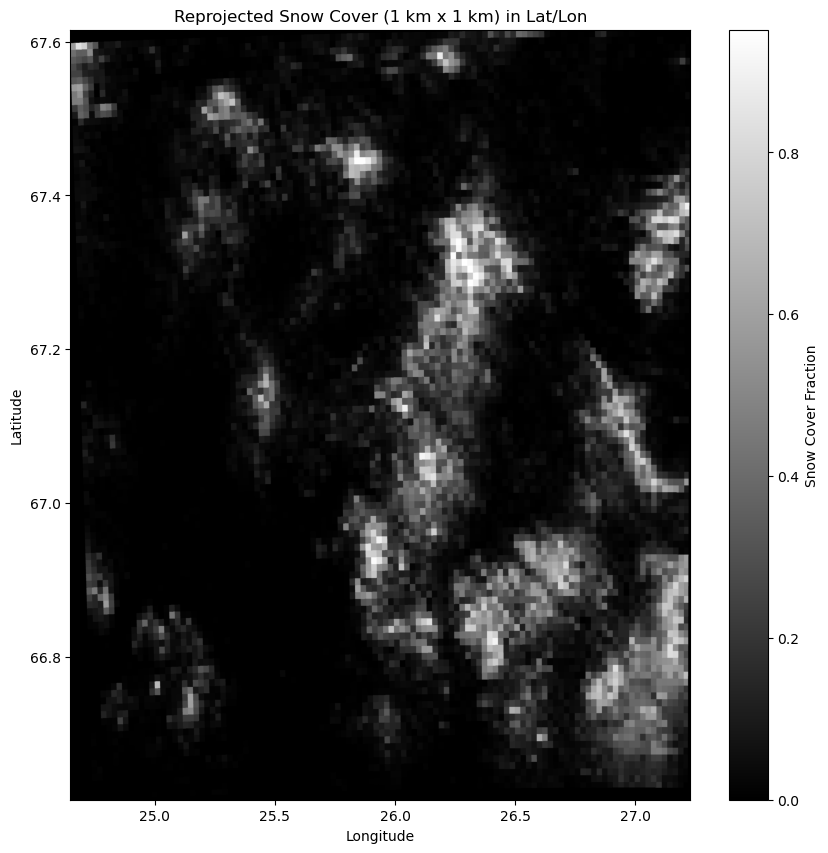

In [1]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer
from matplotlib.colors import ListedColormap

# Define paths for Sentinel-2 and DEM files
sentinel_path = "../data_store/data/S2B_MSIL2A_20230515T095559_N0509_R122_T35WMQ_20230515T113307.SAFE/GRANULE/L2A_T35WMQ_A032323_20230515T095746/IMG_DATA/R20m/"

band3_file = sentinel_path + "T35WMQ_20230515T095559_B03_20m.jp2"   # Green
band4_file = sentinel_path + "T35WMQ_20230515T095559_B04_20m.jp2"   # Red
band8a_file = sentinel_path + "T35WMQ_20230515T095559_B8A_20m.jp2"  # NIR
band11_file = sentinel_path + "T35WMQ_20230515T095559_B11_20m.jp2"  # SWIR
band12_file = sentinel_path + "T35WMQ_20230515T095559_B12_20m.jp2"  # SWIR

# Load Sentinel-2 bands and DEM data
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs, src

band3, transform_band3, crs_band3, src_band3 = load_raster(band3_file)
band4, transform_band4, crs_band4, src_band4 = load_raster(band4_file)
band8a, transform_band8a, crs_band8a, src_band8a = load_raster(band8a_file)
band11, transform_band11, crs_band11, src_band11 = load_raster(band11_file)
band12, transform_band12, crs_band12, src_band12 = load_raster(band12_file)

# Create SWIR composite using bands 12, 8A, and 4 (for visualization)
def create_swir_composite(band12, band8a, band4):
    composite = np.dstack((band12, band8a, band4))
    return composite

# Create SWIR composite and mask (if needed)
swir_composite = create_swir_composite(band12, band8a, band4)

def create_mask(swir_composite):
    """
    Generates a mask where active areas are marked and inactive areas are set to NaN.
    """
    # Thresholds based on the description of the features
    water_marsh_mask = ((swir_composite[:, :, 0] < 1200))  # Dark in SWIR (water/marsh)
    cloud_mask = (swir_composite[:, :, 0] > 5000) & (swir_composite[:, :, 1] > 5000) & (swir_composite[:, :, 2] > 5000)  # White clouds
    
    # Combine all masks
    combined_mask = np.logical_or.reduce([water_marsh_mask, cloud_mask])
    #print(combined_mask)
    
    # Set mask to NaN where it's not active, and 1 where it is active
    combined_mask = np.where(combined_mask, 1, np.nan)
    
    return combined_mask
    
mask = create_mask(swir_composite)  # Mask generation (can be omitted if not needed)

def calculate_ndfsi(green_band, swir_band):
    """
    Calculate the NDFSI using Green (Band 3) and SWIR (Band 12).
    """
    ndfsi = (green_band - swir_band) / (green_band + swir_band)
    return ndfsi

ndfsi = calculate_ndfsi(band3, band11)

def apply_mask(ndfsi, mask):
    """
    Apply the mask to the NDFSI array. Masked areas will be set to NaN.
    """
    # Set NDFSI values where the mask is NaN to the NDFSI value, and everything else to NaN
    masked_ndfsi = np.where(np.isnan(mask), ndfsi, np.nan)
    return masked_ndfsi

masked_ndfsi = apply_mask(ndfsi, mask)

def apply_snow_threshold(ndfsi, threshold):
    """
    Apply a snow threshold to the NDFSI. 
    Below the threshold, set values to 1 (snow), and above it, set to 0 (no snow).
    """
    snow_mask = np.where(ndfsi <= threshold, 1, 0)
    return snow_mask

# Apply the threshold to create a binary snow mask
threshold = 0.4
snow_mask = apply_snow_threshold(masked_ndfsi, threshold)

def average_snow_cover_in_blocks(snow_mask, transform, block_size_meters=1000):
    """
    Calculate the fractional snow cover in 1 km x 1 km blocks.
    """
    pixel_size_x = abs(transform[0])
    pixel_size_y = abs(transform[4])

    # Calculate the number of pixels that correspond to the block size (1 km x 1 km)
    block_size_x = int(block_size_meters / pixel_size_x)
    block_size_y = int(block_size_meters / pixel_size_y)
    
    # Get the dimensions of the snow mask
    rows, cols = snow_mask.shape
    
    # Initialize an array for the averaged snow cover
    averaged_snow_cover = np.full_like(snow_mask, np.nan, dtype=float)
    
    # Iterate over the blocks
    for i in range(0, rows, block_size_y):
        for j in range(0, cols, block_size_x):
            # Extract the block
            block = snow_mask[i:i+block_size_y, j:j+block_size_x]
            
            # Calculate the mean of the block, ignoring NaNs
            if np.isnan(block).all():
                block_mean = np.nan
            else:
                block_mean = np.nanmean(block)
            
            # Assign the mean value to the entire block
            averaged_snow_cover[i:i+block_size_y, j:j+block_size_x] = block_mean
    
    return averaged_snow_cover

averaged_snow_cover = average_snow_cover_in_blocks(snow_mask, transform_band3)

def reproject_and_get_latlon(src_array, src_transform, src_crs, dst_crs='EPSG:4326'):
    """
    Reproject a raster array to latitude/longitude coordinates (EPSG:4326).
    Returns the reprojected array and the lat/lon coordinates for plotting.
    """
    # Calculate the bounds for the source array
    bounds = rasterio.transform.array_bounds(src_array.shape[0], src_array.shape[1], src_transform)
    
    # Calculate the transformation and shape for the output CRS
    dst_transform, width, height = calculate_default_transform(
        src_crs, dst_crs, src_array.shape[1], src_array.shape[0], *bounds)

    # Create an empty array for the reprojected data
    dst_array = np.empty((height, width), dtype=np.float32)

    # Reproject the source data to the destination CRS
    reproject(
        source=src_array,
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

    # Calculate latitude and longitude values using the destination transform
    lon, lat = pixel_to_latlon(dst_transform, dst_crs, width, height)

    return dst_array, lon, lat, dst_transform

def pixel_to_latlon(transform, crs, width, height):
    """
    Convert pixel coordinates to latitude/longitude coordinates (EPSG:4326).
    """
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    xs, ys = np.meshgrid(np.arange(width), np.arange(height))
    lon, lat = rasterio.transform.xy(transform, ys, xs, offset='center')
    lon = np.array(lon)
    lat = np.array(lat)
    lon_lat_transformed = np.vectorize(lambda x, y: transformer.transform(x, y))(lon, lat)
    return lon_lat_transformed[0], lon_lat_transformed[1]

# Example usage for the snow cover map:
reprojected_snow_cover, snow_lon, snow_lat, snow_transform = reproject_and_get_latlon(
    averaged_snow_cover, transform_band3, crs_band3)

plt.figure(figsize=(10, 10))
plt.imshow(reprojected_snow_cover, cmap='gray', extent=(snow_lon.min(), snow_lon.max(), snow_lat.min(), snow_lat.max()), aspect='auto')
plt.colorbar(label='Snow Cover Fraction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Reprojected Snow Cover (1 km x 1 km) in Lat/Lon')
plt.show()

# DEM

Searching for .tif files in the directory...
Total .tif files found: 324
DEM merging completed.


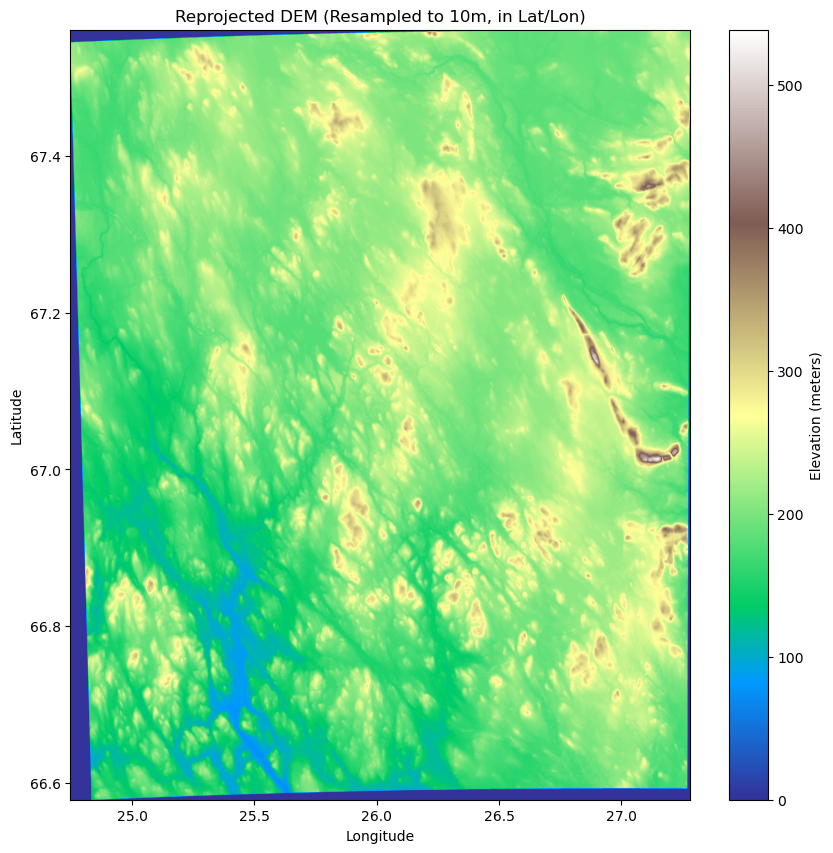

In [2]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject
import matplotlib.pyplot as plt
from pyproj import Transformer

# Define the base directory containing DEM files
base_directory = '../data_store/data/korkeusmalli/hila_2m/etrs-tm35fin-n2000/'

def find_all_tif_files(base_dir):
    """
    Find all .tif files recursively in the given directory.
    """
    print("Searching for .tif files in the directory...")
    tif_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.tif'):
                full_path = os.path.join(root, file)
                tif_files.append(full_path)
                # print(f"Found: {full_path}")
    print(f"Total .tif files found: {len(tif_files)}")
    return tif_files

# Find all .tif files in the directory
dem_files = find_all_tif_files(base_directory)

def resample_and_merge_dems(dem_files):
    """
    Resample all DEM files to 10m resolution and merge them using rasterio's merge function.
    """
    datasets = []
    dem_crs = None

    for i, dem_file in enumerate(dem_files):
        # print(f"Processing file {i+1}/{len(dem_files)}: {dem_file}")
        with rasterio.open(dem_file) as src:
            if dem_crs == None:
                dem_crs = src.crs
            try:
                #resampled_data, resampled_transform, resampled_crs = resampled_data, src.transform*src.transform.scale(5,5), src.crs
                resampled_data = src.read(1, out_shape=(src.width//5, src.height//5), resampling=Resampling.average)

                memfile = MemoryFile()
                mem_dataset = memfile.open(
                    driver='GTiff',
                    height=resampled_data.shape[0],
                    width=resampled_data.shape[1],
                    count=1,
                    dtype=resampled_data.dtype,
                    crs=src.crs,
                    transform=src.transform*src.transform.scale(5,5)
                )
                mem_dataset.write(resampled_data, 1)
                # mem_dataset = create_memory_dataset(resampled_data, resampled_transform, resampled_crs)
                
                datasets.append(mem_dataset)
                # print(f"File {i+1} resampled and stored in memory.")
            except Exception as e:
                print(f"Error processing {dem_file}: {e}")

    # Merge the in-memory datasets
    try:
        mosaic, out_trans = merge(datasets)
        print("DEM merging completed.")
    except Exception as e:
        print(f"Error during merging: {e}")
        return None, None, None

    # Close all in-memory files
    for dataset in datasets:
        dataset.close()

    return mosaic, out_trans, dem_crs

merged_dem, merged_transform, dem_crs = resample_and_merge_dems(dem_files)

def reproject_and_get_latlon(src_array, src_transform, src_crs, dst_crs='EPSG:4326'):
    """
    Reproject a raster array to latitude/longitude coordinates (EPSG:4326).
    Returns the reprojected array and the lat/lon coordinates for plotting.
    """
    # Calculate the bounds for the source array
    bounds = rasterio.transform.array_bounds(src_array.shape[0], src_array.shape[1], src_transform)
    
    # Calculate the transformation and shape for the output CRS
    dst_transform, width, height = calculate_default_transform(
        src_crs, dst_crs, src_array.shape[1], src_array.shape[0], *bounds)

    # Create an empty array for the reprojected data
    dst_array = np.empty((height, width), dtype=np.float32)

    # Reproject the source data to the destination CRS
    reproject(
        source=src_array,
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

    # Calculate latitude and longitude values using the destination transform
    lon, lat = pixel_to_latlon(dst_transform, dst_crs, width, height)

    return dst_array, lon, lat, dst_transform

def pixel_to_latlon(transform, crs, width, height):
    """
    Convert pixel coordinates to latitude/longitude coordinates (EPSG:4326).
    """
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    xs, ys = np.meshgrid(np.arange(width), np.arange(height))
    lon, lat = rasterio.transform.xy(transform, ys, xs, offset='center')
    lon = np.array(lon)
    lat = np.array(lat)
    lon_lat_transformed = np.vectorize(lambda x, y: transformer.transform(x, y))(lon, lat)
    return lon_lat_transformed[0], lon_lat_transformed[1]

# Example usage for the DEM:
reprojected_dem, dem_lon, dem_lat, dem_transform = reproject_and_get_latlon(
    merged_dem[0], merged_transform, 'EPSG:3067')

plt.figure(figsize=(10, 10))
plt.imshow(reprojected_dem, cmap='terrain', extent=(dem_lon.min(), dem_lon.max(), dem_lat.min(), dem_lat.max()), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Reprojected DEM (Resampled to 10m, in Lat/Lon)')
plt.show()

# Combination

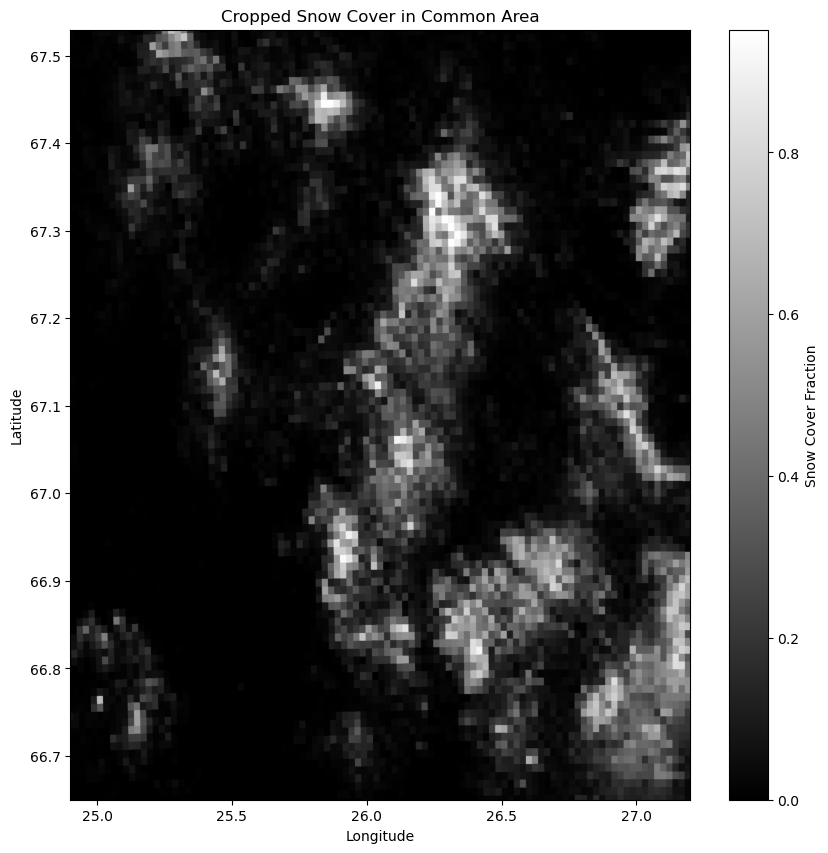

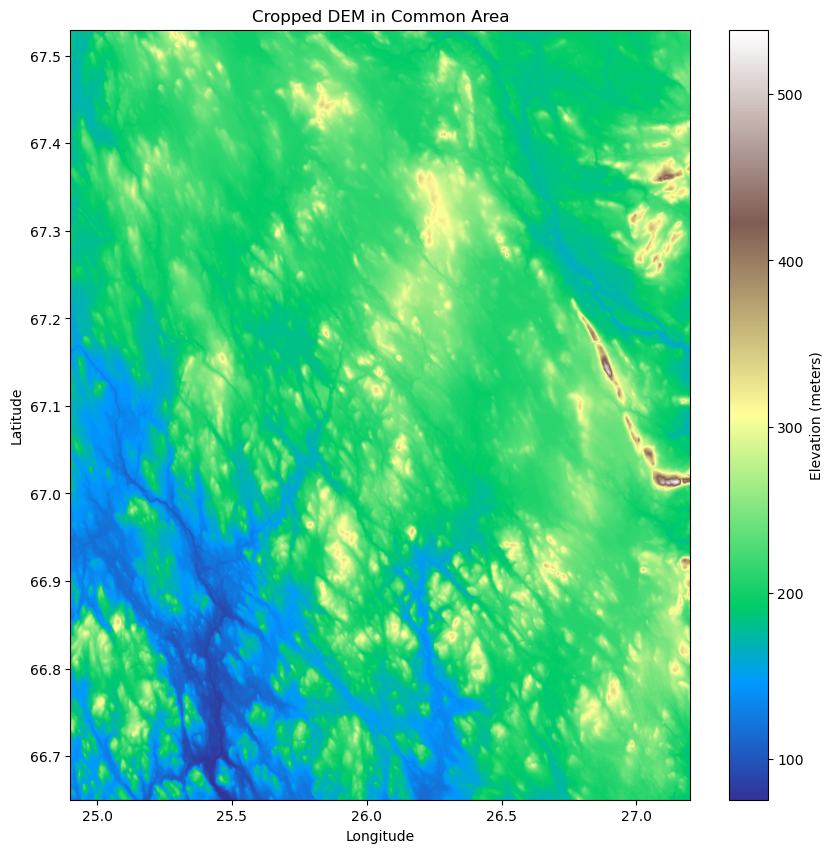

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def crop_to_common_area(data1, lon1, lat1, data2, lon2, lat2, 
                        lat_bounds=None, lon_bounds=None):
    # Determine the common extents if lat/lon bounds are not provided
    if lon_bounds is None:
        min_lon = max(lon1.min(), lon2.min())
        max_lon = min(lon1.max(), lon2.max())
    else:
        min_lon, max_lon = lon_bounds
    
    if lat_bounds is None:
        min_lat = max(lat1.min(), lat2.min())
        max_lat = min(lat1.max(), lat2.max())
    else:
        min_lat, max_lat = lat_bounds

    # Find indices for cropping data1
    lon1_indices = np.where((lon1[0, :] >= min_lon) & (lon1[0, :] <= max_lon))[0]
    lat1_indices = np.where((lat1[:, 0] >= min_lat) & (lat1[:, 0] <= max_lat))[0]
    
    # Find indices for cropping data2
    lon2_indices = np.where((lon2[0, :] >= min_lon) & (lon2[0, :] <= max_lon))[0]
    lat2_indices = np.where((lat2[:, 0] >= min_lat) & (lat2[:, 0] <= max_lat))[0]

    # Crop the data arrays
    cropped_data1 = data1[np.ix_(lat1_indices, lon1_indices)]
    cropped_lon1 = lon1[np.ix_(lat1_indices, lon1_indices)]
    cropped_lat1 = lat1[np.ix_(lat1_indices, lon1_indices)]
    
    cropped_data2 = data2[np.ix_(lat2_indices, lon2_indices)]
    cropped_lon2 = lon2[np.ix_(lat2_indices, lon2_indices)]
    cropped_lat2 = lat2[np.ix_(lat2_indices, lon2_indices)]

    return cropped_data1, cropped_lon1, cropped_lat1, cropped_data2, cropped_lon2, cropped_lat2

# Crop the snow cover and DEM data to their common extent
cropped_snow_cover, cropped_snow_lon, cropped_snow_lat, cropped_dem, cropped_dem_lon, cropped_dem_lat = crop_to_common_area(
    reprojected_snow_cover, snow_lon, snow_lat, reprojected_dem, dem_lon, dem_lat, lat_bounds=(66.65,67.53), lon_bounds=(24.9,27.2)
)

# Plot the cropped snow cover data
plt.figure(figsize=(10, 10))
plt.imshow(cropped_snow_cover, extent=(cropped_snow_lon.min(), cropped_snow_lon.max(), cropped_snow_lat.min(), cropped_snow_lat.max()), cmap='gray', aspect='auto')
plt.colorbar(label='Snow Cover Fraction')
# plt.yticks(np.arange(66.5,67.7,0.1))
# plt.xticks(np.arange(24.5,27.5,0.1))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cropped Snow Cover in Common Area')
plt.show()

# Plot the cropped DEM data
plt.figure(figsize=(10, 10))
plt.imshow(cropped_dem, extent=(cropped_dem_lon.min(), cropped_dem_lon.max(), cropped_dem_lat.min(), cropped_dem_lat.max()), cmap='terrain', aspect='auto')
plt.colorbar(label='Elevation (meters)')
# plt.yticks(np.arange(66.5,67.7,0.1))
# plt.xticks(np.arange(24.5,27.5,0.1))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cropped DEM in Common Area')
plt.show()

# Topography

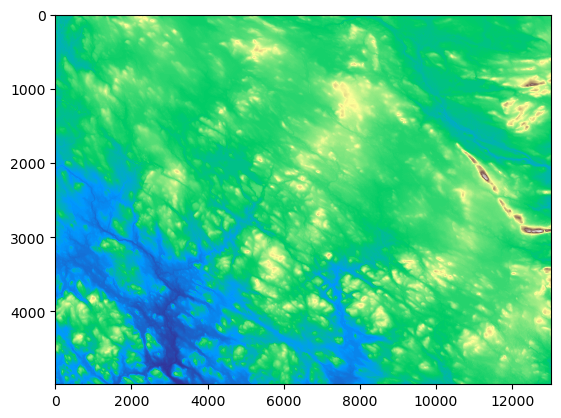

DEM Longitude Resolution (meters): 19.660795671051545
DEM Latitude Resolution (meters): 19.529040787703224
Scale Factor (Longitude): 50.86264140735641
Scale Factor (Latitude): 51.205791972622954
Original DEM shape: (4982, 13023)
New DEM shape: (Height: 255107, Width: 662384)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import generic_gradient_magnitude, sobel
import rasterio

def resample_dem_to_target_resolution(dem, dem_lon, dem_lat, target_resolution=1000):
    """
    Resample the DEM directly to the specified resolution (default is 1 km).
    
    Parameters:
    - dem: The original DEM array.
    - dem_lon, dem_lat: The longitude and latitude arrays for the DEM.
    - target_resolution: The target resolution in meters (default is 1000 meters for 1 km).
    
    Returns:
    - resampled_dem: DEM resampled to the target resolution.
    - new_lon, new_lat: Longitude and latitude arrays corresponding to the resampled DEM.
    """
    # Calculate the current step sizes of the DEM in degrees
    dem_lon_step = abs(dem_lon[0, 1] - dem_lon[0, 0])
    dem_lat_step = abs(dem_lat[1, 0] - dem_lat[0, 0])
    
    # Approximate conversion factor from degrees to meters (at the equator)
    lon_conversion_factor = 111320  # meters per degree longitude
    lat_conversion_factor = 110574  # meters per degree latitude

    # Convert DEM steps to meters
    dem_lon_resolution_meters = dem_lon_step * lon_conversion_factor
    dem_lat_resolution_meters = dem_lat_step * lat_conversion_factor
    
    # Calculate the scale factors needed to resample the DEM to the target resolution
    scale_factor_lon = target_resolution / dem_lon_resolution_meters
    scale_factor_lat = target_resolution / dem_lat_resolution_meters
    
    # Calculate the new dimensions for the DEM based on the scale factors
    new_height = int(dem.shape[0] * scale_factor_lat)
    new_width = int(dem.shape[1] * scale_factor_lon)
    
    # Print information for debugging
    print(f"DEM Longitude Resolution (meters): {dem_lon_resolution_meters}")
    print(f"DEM Latitude Resolution (meters): {dem_lat_resolution_meters}")
    print(f"Scale Factor (Longitude): {scale_factor_lon}")
    print(f"Scale Factor (Latitude): {scale_factor_lat}")
    print(f"Original DEM shape: {dem.shape}")
    print(f"New DEM shape: (Height: {new_height}, Width: {new_width})")
    
    # Define the source and destination transforms
    src_transform = rasterio.transform.from_bounds(
        dem_lon.min(), dem_lat.min(), dem_lon.max(), dem_lat.max(),
        dem.shape[1], dem.shape[0]
    )
    dst_transform = rasterio.transform.from_bounds(
        dem_lon.min(), dem_lat.min(), dem_lon.max(), dem_lat.max(),
        new_width, new_height
    )
    
    # Initialize the array for the resampled DEM
    resampled_dem = np.empty((new_height, new_width), dtype=np.float32)
    
    # Reproject the DEM to match the target resolution
    reproject(
        source=dem,
        destination=resampled_dem,
        src_transform=src_transform,
        src_crs='EPSG:4326',
        dst_transform=dst_transform,
        dst_crs='EPSG:4326',
        resampling=Resampling.average
    )
    
    # Generate new longitude and latitude grids for the resampled DEM
    new_lon = np.linspace(dem_lon.min(), dem_lon.max(), new_width)
    new_lat = np.linspace(dem_lat.min(), dem_lat.max(), new_height)
    new_lon_grid, new_lat_grid = np.meshgrid(new_lon, new_lat)
    
    return resampled_dem, new_lon_grid, new_lat_grid
    
plt.imshow(cropped_dem, cmap='terrain', aspect='auto')
plt.show()

resampled_dem, resampled_dem_lon, resampled_dem_lat = resample_dem_to_target_resolution(
    cropped_dem, cropped_dem_lon, cropped_dem_lat, target_resolution=1000
)

plt.imshow(resampled_dem, cmap='terrain', aspect='auto')